In [2]:
# import required libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

C:\Users\ME\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ME\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

In [4]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# shape of df

retail.shape

(541909, 8)

In [6]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*retail.isnull().sum()/len(retail),2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [9]:
# Changing the datatype of Customer Id 

retail['CustomerID'] = retail['CustomerID'].astype(str)

In [10]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [12]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [18]:
# New Attribute : Recency

# Convert to datetime to proper datatype

# from datetime import datetime

# def standardize_date_format(date_str):
#     # Possible date formats in the input
#     date_formats = ["%d-%m-%Y %H:%M", "%d/%m/%Y %H:%M", "%d/%m/%Y %H:%M:%S", "%m/%d/%Y %H:%M", "%m/%d/%Y %H:%M:%S"]
    
#     for date_format in date_formats:
#         try:
#             date_obj = datetime.strptime(date_str, date_format)
#             return date_obj.strftime("%d-%m-%Y %H:%M")
#         except ValueError:
#             continue
    
#     # If no formats matched, raise an error
#     raise ValueError(f"Date format for '{date_str}' is not recognized.")
    
# retail['InvoiceDate'] = retail['InvoiceDate'].apply(standardize_date_format)

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 406829, dtype: datetime64[ns]

In [19]:
# Compute the maximum date to know the last transaction date

max_date = retail['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [20]:
# Compute the difference between max date and transaction date

# retail['Diff'] = max_date - retail['InvoiceDate']
retail['Diff'] = (max_date - retail['InvoiceDate']).dt.days
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373


In [21]:
# Compute recency of customer

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [22]:
# Merge the dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


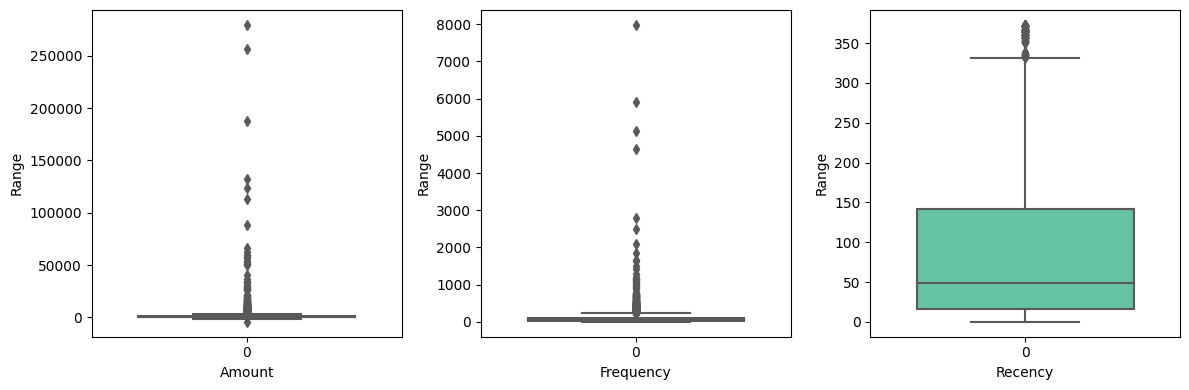

<Figure size 640x480 with 0 Axes>

In [23]:
# Outlier Analysis of Amount Frequency and Recency

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data = rfm['Amount'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.xlabel('Amount')
plt.ylabel('Range')

plt.subplot(1, 3, 2)
sns.boxplot(data = rfm['Frequency'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.xlabel('Frequency')
plt.ylabel('Range')

plt.subplot(1, 3, 3)
sns.boxplot(data = rfm['Recency'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.xlabel('Recency')
plt.ylabel('Range')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [24]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.25)
Q3 = rfm.Amount.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [25]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3629, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-1.056277,-1.076164,2.351537
1,1.355840,-0.393805,-0.239067
2,1.302571,0.594439,-0.817050
3,-0.607471,-0.723220,2.186399
4,1.017853,1.112091,-0.641591


In [27]:
type(rfm_df_scaled)

pandas.core.frame.DataFrame

In [28]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [29]:
kmeans.labels_

array([2, 3, 3, ..., 2, 0, 3])

In [30]:
set(kmeans.labels_)

{0, 1, 2, 3}

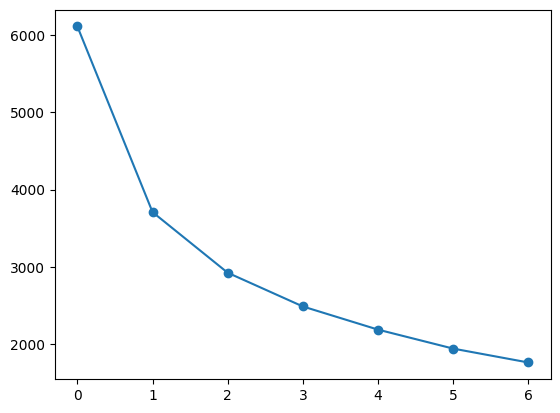

In [31]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd,marker = 'o')

In [32]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [33]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1
5,12352.0,1545.41,95,35,2


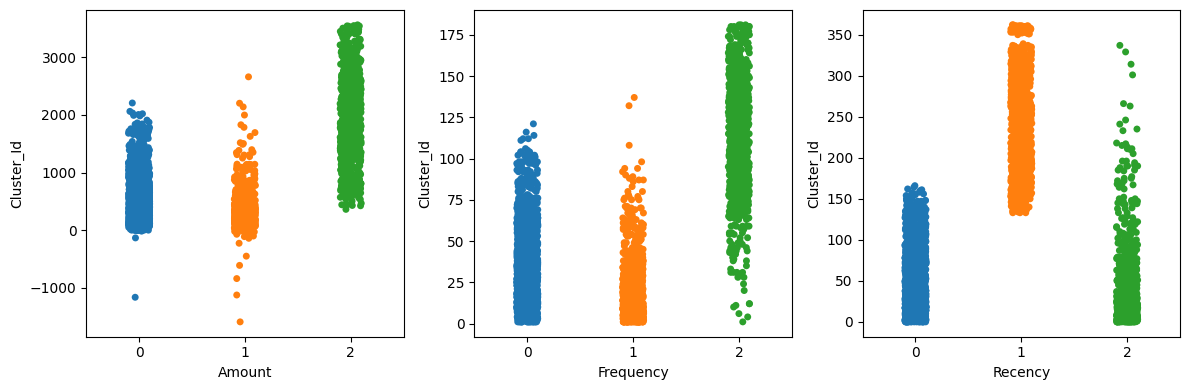

<Figure size 640x480 with 0 Axes>

In [34]:

# Plots of Amount Frequency and Recency

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.stripplot(x = 'Cluster_Id', y = 'Amount', data = rfm)
plt.xlabel('Amount')
plt.ylabel('Cluster_Id')

plt.subplot(1, 3, 2)
sns.stripplot(x = 'Cluster_Id', y = 'Frequency', data = rfm)
plt.xlabel('Frequency')
plt.ylabel('Cluster_Id')

plt.subplot(1, 3, 3)
sns.stripplot(x = 'Cluster_Id', y = 'Recency', data = rfm)
plt.xlabel('Recency')
plt.ylabel('Cluster_Id')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()